# Regression Trees (CART)

Wir bezeichenen $X \in \mathbb{R}^p$ als einen $p$-dimensionalen Zufalls-Eingabe-Vector und $Y \in \mathbb{R}$ als einen reellwertigen Zufalls-Ausgabe-Vektor mit einer bivariaten Verteilung $Pr(X,Y)$. Mit Hilfe von der Eingabe $X$ wollen wir Ausgabevektor $Y$ vorhesagen. 
Baum verfahren Teilen den Eingabe-Raum $\mathbb{R}^p$ rekursiv in $p$-dimensionale Quader auf. Für jeden Quader wird dann ein einfaches Modell, wie z.B. die Konstante Funktion, für die Vorhersage verwendet. Wir wollen an dieser Stelle uns auf die Betrachtung von binären Regressions Bäumen beschränken. Diese führen in jedem Schritt nur eine Teilung eines Quaders durch. Sie lassen sich einfach beschreiben als Bäume die mehrere Aufteilungen in einem Schritt ausführen. Zudem lassen sich mehrfache Aufteilung auch als hintereinander angewendete Zweiteilungen beschreiben.

Das Model für einen Baum der den Eingabe-Raum in $M$ Quader aufteilt lässt sich wie folgt schreiben:

$$f(x) = \sum_{m=1}^M c_m I(x\in Q_m) $$

Hierbei ist $c_m$ eine Konstante zur Schätzung der Variablen $Y$ im Quader $Q_m$. Wenn wir die Summe der quadratischen Fehler $\sum(Y-f(x))^2$ als Kriterium ansetzen, lässt sich zeigen, dass

$$\hat{c}_m = \text{ave}(y_i|x_i \in Q_m) $$

die beste Wahl ist.


## Training (Baum wachsen lassen)

Aufgrund der langen Rechnzeit ist es nicht Anwendbar alle möglichen binäre Aufteilungen zu probieren, um eine beste Aufteilung zu finden. Deshalb bedient man sich einem 'greedy' Algorithmus

1. Beginne mit allen Daten
2. Teile die Daten in zwei Teile, entlang einer Eingabe-Variablen $j$ und an einem bestimmten Teilungspunkt $s$:
$$ Q_1(j,s) = \{ X | X_j \leq s \} \text{ und } Q_2(j,s) = \{ X | X_j \gt s \}$$
wobei wir j und s so wählen, dass
$$ \min_{j,s} \left[ \min_{c_1} \sum_{x_i \in Q_1(j,s)} (y_i-c_1)^2 + \min_{c_2} \sum_{x_i \in Q_2(j,s)} (y_i-c_2)^2\right]$$
3. Wenn die beste Teilung gefunden wurde, Teile die Daten in zwei resultierenden Quader auf
4. Wiederhole diese Schritte für beide Quader beginnend mit Schritt 2.

**Fragen:**
- Wie lange Fahre ich mit dieser Rekursion fort?
- Wäre die Beschränkung auf eine Maximaltiefe sinnvoll?
- Mit welchem uns bekannten Modell hat dieses Verfahren Ähnlichkeit und warum?


Ein Beispiel für Regression-Trees am Beispiel von Werte von Häusern in Kalifornien

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns 
sns.set()

from sklearn.tree import DecisionTreeRegressor 

import graphviz 

In [2]:
data = pd.read_csv("../../data/housing/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Nehmen wir nur die Ortskoordinaten als Eingabe $X$ für das KNR-Modell und den 'median_house_value' als Ausgabevariable $Y$, können wir durch Anpassen des Parameters $k$ sehen wie eine größer Wahl der Nachbarschaft ein Glättung des 'Bildes' entspricht. 

In [3]:
max_depth = 3

dTree = DecisionTreeRegressor(max_depth=max_depth)
dTree.fit(data[['latitude', 'longitude']], data['median_house_value'])
data['predicted_value'] = dTree.predict(data[['latitude', 'longitude']])

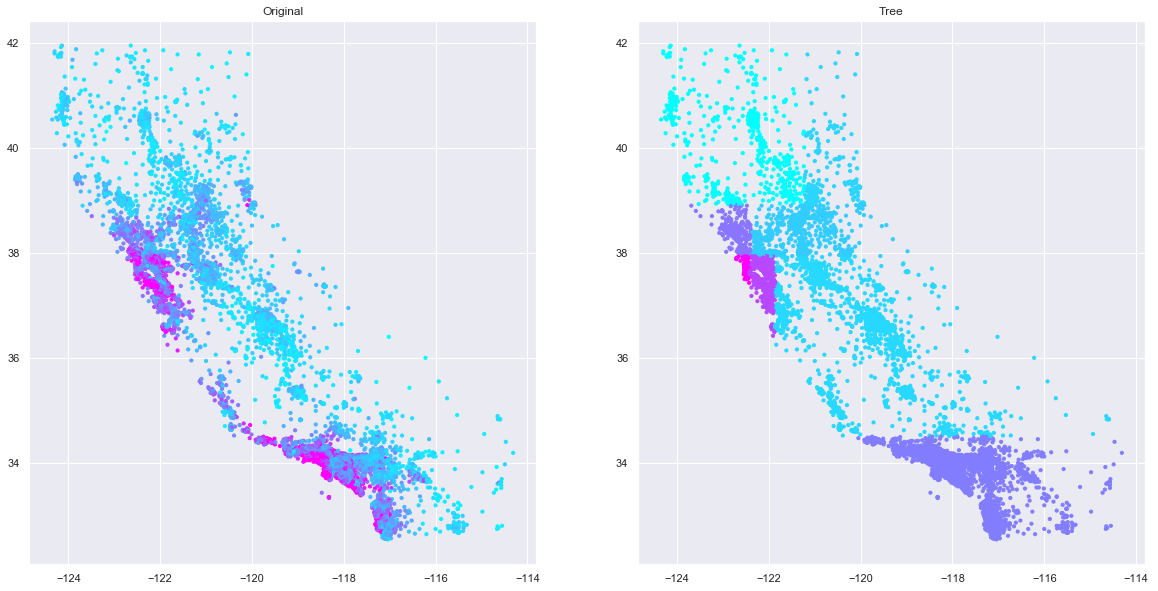

In [4]:
fig = plt.figure(figsize=(20,10))
sub1 = plt.subplot(1,2,1)
sub1.set_title('Original')
plt.scatter(x=data['longitude'], y=data['latitude'], c=data['median_house_value'], s=10, cmap='cool');

sub2=plt.subplot(1,2,2)
sub2.set_title('Tree')
plt.scatter(x=data['longitude'], y=data['latitude'], c=data['predicted_value'], s=10, cmap='cool');

In [5]:
from sklearn.tree import _tree

def tree_to_rectangles(tree, feature_names, lat, lon):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))
    
    rectangles = []
    
    def recurse(node, lat, lon, rectangles):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            
            lon_left = lon.copy()
            lat_left = lat.copy()
            
            lon_right = lon.copy()
            lat_right = lat.copy()
            
            if name == "lat":
                lat_left[1] = tree_.threshold[node] 
                lat_right[0] = tree_.threshold[node]
                recurse(tree_.children_left[node], lat_left, lon_left, rectangles)
                recurse(tree_.children_right[node], lat_right, lon_right, rectangles)
            else:
                lon_left[1] = tree_.threshold[node] 
                lon_right[0] = tree_.threshold[node]
                recurse(tree_.children_left[node], lat_left, lon_left, rectangles)
                recurse(tree_.children_right[node], lat_right, lon_right, rectangles)
            
        else:
            rectangles.append([lat[0],lat[1],lon[0],lon[1]])

    recurse(0, lat, lon, rectangles)
    return rectangles
    

In [6]:
lat = np.zeros(2)
lon = np.zeros(2)
lat[0] = data['latitude'].min() 
lat[1] = data['latitude'].max()

lon[0] = data['longitude'].min() 
lon[1] = data['longitude'].max()

print(lat, lon)
rect = tree_to_rectangles(dTree, ['lat','lon'], lat, lon)

pd_rect = pd.DataFrame(rect, columns=['lat_0','lat_1','lon_0','lon_1'])
pd_rect.head() 

[32.54 41.95] [-124.35 -114.31]
def tree(lat, lon):


,lat_0,lat_1,lon_0,lon_1
0,32.540000,37.934998,-124.350000,-122.425003
1,32.540000,37.934998,-122.425003,-121.865005
2,32.540000,34.504997,-121.865005,-114.310000
3,34.504997,37.934998,-121.865005,-114.310000
4,37.934998,38.915001,-124.350000,-122.380005


In [7]:
coordinates = []
for row in rect:
    for i in [0,1]:
        for j in [0,1]:
            coordinates.append([row[i],row[2 + j]])

pd_coord = pd.DataFrame(coordinates)
    

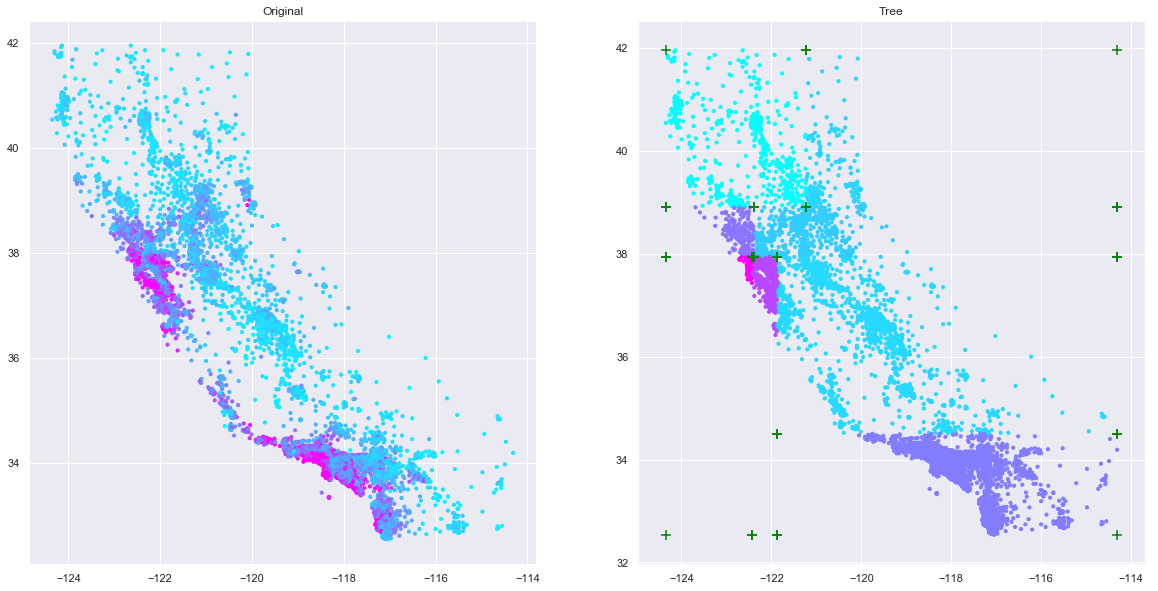

In [8]:
fig = plt.figure(figsize=(20,10))
sub1 = plt.subplot(1,2,1)
sub1.set_title('Original')
plt.scatter(x=data['longitude'], y=data['latitude'], c=data['median_house_value'], s=10, cmap='cool');

sub2=plt.subplot(1,2,2)
sub2.set_title('Tree')
plt.scatter(x=data['longitude'], y=data['latitude'], c=data['predicted_value'], s=10, cmap='cool');
plt.scatter(x=pd_coord[1], y=pd_coord[0], marker='+', c='green', s=100);

---

## Print tree decisions as output 

In [9]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [10]:
tree_to_code(dTree,['lat','lon'])

def tree(lat, lon):
  if lat <= 37.93499755859375:
    if lon <= -121.86500549316406:
      if lon <= -122.42500305175781:
        return [[353614.54243542]]
      else:  # if lon > -122.42500305175781
        return [[278916.75177041]]
    else:  # if lon > -121.86500549316406
      if lat <= 34.50499725341797:
        return [[223699.95562454]]
      else:  # if lat > 34.50499725341797
        return [[130490.71662684]]
  else:  # if lat > 37.93499755859375
    if lat <= 38.915000915527344:
      if lon <= -122.3800048828125:
        return [[231814.24784483]]
      else:  # if lon > -122.3800048828125
        return [[141957.52]]
    else:  # if lat > 38.915000915527344
      if lon <= -121.22500610351562:
        return [[89331.24759615]]
      else:  # if lon > -121.22500610351562
        return [[133424.33460076]]
